# TD1 – feature engineering

# Data Discovery

In [81]:
#Important librairy
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#Install packages
!pip install bokeh
!pip install xgboost

#Import for features
from matplotlib import pyplot as plt
%matplotlib inline
from bokeh.plotting import figure, output_notebook, show
from bokeh.palettes import Turbo256
from bokeh.transform import linear_cmap
from bokeh.palettes import brewer
import seaborn as sns

#Import for model creation
import time
from decimal import *
import sklearn.metrics as metrics
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import AdaBoostRegressor

from xgboost import XGBRegressor
from sklearn.datasets import load_diabetes
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

from sklearn.preprocessing import MinMaxScaler

#Conclusion
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [82]:
# On charge le dataset
df = pd.read_csv("logistique.csv", encoding="latin1")
df.head()

,datedecreationdecommande,providerservice_id,dateexpe
0,2019-11-01 11:40:35.9930000,48,02/11/2019
1,2019-11-01 11:40:35.9700000,48,02/11/2019
2,2019-11-01 10:24:40.8930000,48,02/11/2019
3,2019-11-01 14:24:21.1770000,48,02/11/2019
4,2019-11-01 13:28:35.7900000,48,02/11/2019


In [83]:
# On affiche la dimension du dataset
print('Nombre de ligne : ' +  str(df.shape[1]))
print('Nombre de colonne : ' + str(df.shape[0]))

Nombre de ligne : 3
Nombre de colonne : 572841


In [84]:
# On regarde le type des colonnes
df.dtypes

datedecreationdecommande    object
providerservice_id           int64
dateexpe                    object
dtype: object

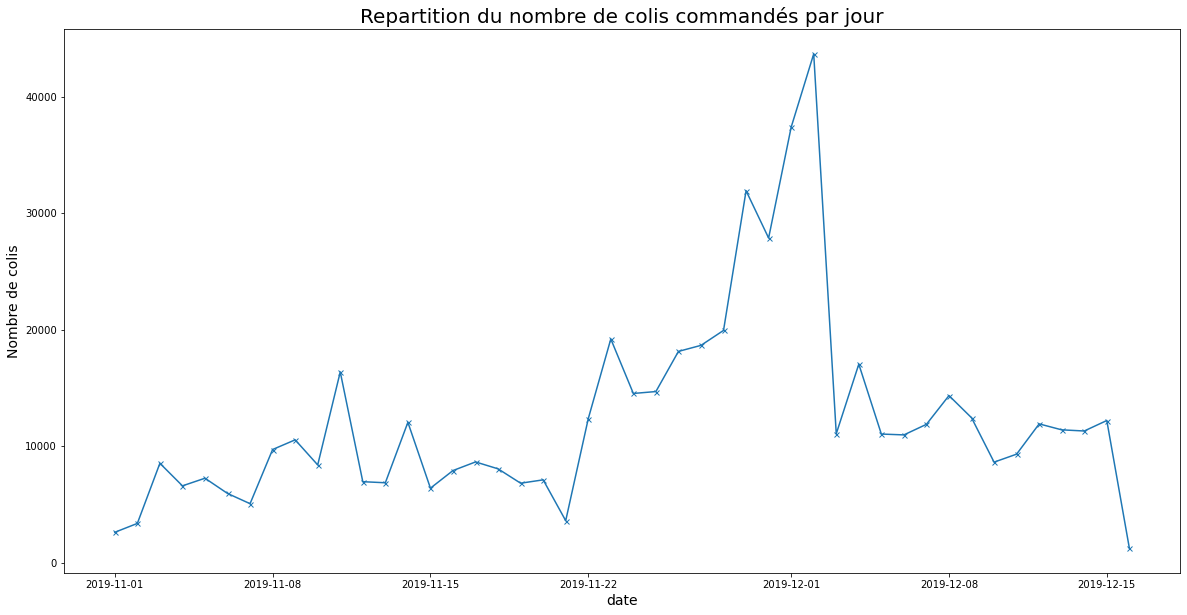

In [85]:
# Nombre de colis par jours
group = df.groupby(pd.to_datetime(df['datedecreationdecommande']).dt.date).size()

# On affiche le résultat
group.plot(y="Nombre de colis", marker="x", markersize=5, figsize=(20,10));
plt.title("Repartition du nombre de colis commandés par jour", fontsize=20)
plt.xlabel('date', fontsize=14)
plt.ylabel('Nombre de colis', fontsize=14)
plt.show()

Un pic important de création de commandes a lieu début décembre, phénomène probablement lié aux fêtes de Noël. Il sera important de le prendre compte lors du fitting du modèle.

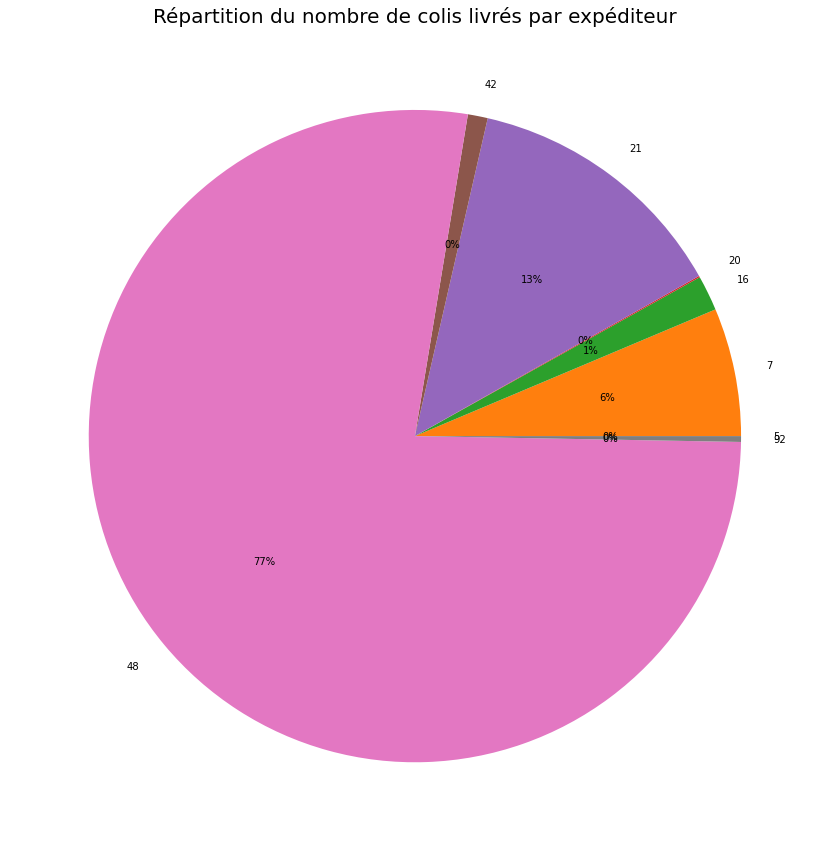

In [86]:
# Nombre de colis par expediteurs
group = df.groupby(['providerservice_id']).size().to_dict()

# On affiche le graphique
BikeSeasons=group
plt.gcf().set_size_inches(15,15)
plt.pie(BikeSeasons.values(),labels=BikeSeasons.keys(), autopct='%1d%%');
plt.title("Répartition du nombre de colis livrés par expéditeur", fontsize=20)
plt.show()

On remarque que l'expéditeur n°48 prend en charge plus des trois-quarts des colis.

# Feature engineering

In [87]:
# Conversion des 2 colonnes en format date
df['datedecreationdecommande'] = pd.to_datetime(df['datedecreationdecommande'])
df['dateexpe'] = pd.to_datetime(df['dateexpe'],format='%d/%m/%Y')

# On sépare la date de création de commande en plusieurs colonnes (jour, heure et minute)
df['dateCreaJour'] = df['datedecreationdecommande'].dt.day
df['dateCreaHeure'] = df['datedecreationdecommande'].dt.hour
df['dateCreaMinute'] = df['datedecreationdecommande'].dt.minute

In [88]:
# On créer une nouvelle colonne pour savoir quel jour de la semaine nous somme
df['dateCreaJourSemaine'] = df['datedecreationdecommande'].dt.dayofweek

# Lundi commencant à 0, on ajoute 1 à toute les colonnes
df['dateCreaJourSemaine'] += 1 

In [89]:
# On créer une nouvelle colonne contenant l'information de la durée d'attente en nombre de jour
# On retire l'heure de la date de commande pour calculer le delta afin d'éviter les erreurs
df['datedecreationdecommande'] = pd.to_datetime(df['datedecreationdecommande']).dt.date
df['dateexpe'] = pd.to_datetime(df['dateexpe']).dt.date

# Cette feature est l'information finale que nous allons essayer de prédire
df['nbJourPreparation'] = (df['dateexpe'] - df['datedecreationdecommande']).dt.days

In [90]:
# On crée une nouvelle liste, une pour les commandes en attente dans l'entrepot
listNbColisAttente = []

# On créer un dictionnaire pour chaque expediteur
listNbColisAttenteParExpe = []

# On créer donc un entier pour réaliser l'incrémentation
nbColisTotal = 0

In [91]:
try:
    df_data = pd.read_csv("newFeatureLogistique.csv", encoding="latin1")
    df = df.join(df_data)
except FileNotFoundError: 
    # On trie le dataframe par la date de création afin d'obtenir le nombre de colis en attente
    for row in df.itertuples():
        # Calcul pour le nombre de colis dans l'entrepot qui ne sont pas encore envoyé durant la création
        df_colisNotAgainSend = df.loc[:nbColisTotal][row.datedecreationdecommande < df.loc[:nbColisTotal].dateexpe]
        listNbColisAttente.append(df_colisNotAgainSend.shape[0])

        # On verifie maintenant celui-ci par rapport à l'expediteur                          
        listNbColisAttenteParExpe.append(df_colisNotAgainSend[df.providerservice_id == row.providerservice_id].shape[0])

        # On incrémente                          
        nbColisTotal = nbColisTotal + 1

        if(nbColisTotal%1000 == 0):
            print("Nombre de colis traités : " + str(nbColisTotal))

    # On copie le resultat dans l'excel
    dictNbColis = {'NbColisAttente':listNbColisAttente,'NbColisAttenteParExpe':listNbColisAttenteParExpe}
    df = pd.DataFrame(dictNbColis)
    df.to_csv("newFeatureLogistique.csv",index=False)

    # On ajoute dans le dataframe
    df["NbColisAttente"] = listNbColisAttente
    df["NbColisAttenteParExpe"] = listNbColisAttenteParExpe

In [92]:
# Les Id etant des nombres, cela pourrais réduire l'efficacité du modele
# On va donc le split en créant une colonne par expediteur
df_expe = pd.get_dummies(list(df['providerservice_id']), prefix='Provider')

# On ajoute nos nouvelles colonnes au dataframe et on l'affiche
df = df.join(df_expe)
df.head()

,datedecreationdecommande,providerservice_id,dateexpe,dateCreaJour,dateCreaHeure,dateCreaMinute,dateCreaJourSemaine,nbJourPreparation,NbColisAttente,NbColisAttenteParExpe,Provider_5,Provider_7,Provider_16,Provider_20,Provider_21,Provider_42,Provider_48,Provider_92
0,2019-11-01,48,2019-11-02,1,11,40,5,1,1,1,0,0,0,0,0,0,1,0
1,2019-11-01,48,2019-11-02,1,11,40,5,1,2,2,0,0,0,0,0,0,1,0
2,2019-11-01,48,2019-11-02,1,10,24,5,1,3,3,0,0,0,0,0,0,1,0
3,2019-11-01,48,2019-11-02,1,14,24,5,1,4,4,0,0,0,0,0,0,1,0
4,2019-11-01,48,2019-11-02,1,13,28,5,1,5,5,0,0,0,0,0,0,1,0


Certaines data sont fausses comme la création de certaines commande en 1980 ou d'autre possèdant une date d'envoie plus veille que la date d'achats. Nous ne possèdons aucune informations sur les raisons de ses erreurs, il est donc préférable de les supprimées plutôt que de tenter de les corriger.

In [93]:
#Supression des données qui semble éronnées
indexNames = df[ df['nbJourPreparation'] < 0 ].index

# On supprime leurs index
df.drop(indexNames , inplace=True)

In [94]:
#On regarde le nombre de jour de preparation minimun et maximun afin de regarder la cohérence de nos données
print("Nombre de jour minimun : " + str(df["nbJourPreparation"].min()))
print("Nombre de jour maximun : " + str(df["nbJourPreparation"].max()))

Nombre de jour minimun : 0
Nombre de jour maximun : 15


In [95]:
# Le nombre de jour minimun semble bon, cependant le maximun est relativement élévé et nous allons donc regardé si cela est un cas isolé
df.groupby(['nbJourPreparation']).size()
# On peut voir ci-dessous que 9 et 15 jours sont les nombres maximun de jour pour la préparation d'un colis et que celui ci est sont des cas isolés

nbJourPreparation
0      14474
1     140811
2     201414
3     123320
4      59596
5      26884
6       3138
7       3068
8        100
9          1
15         1
dtype: int64

In [96]:
# On supprime les anciennes colonnes initiales qui sont maintenant obcelettes
df = df.drop('datedecreationdecommande',axis = 1)
df = df.drop('providerservice_id',axis = 1)
df = df.drop('dateexpe',axis = 1)

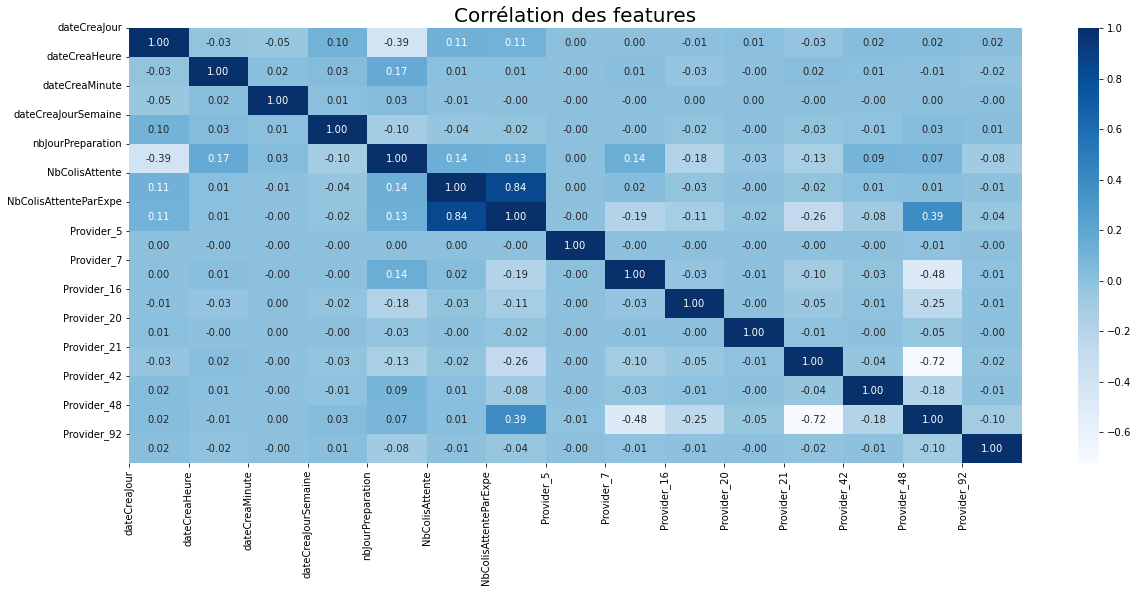

In [97]:
# On regarde la corrélation entre les variables
corr = df.corr()

# On plot le graph et on génère la carte couleur
fig, ax = plt.subplots(figsize=(20, 8))
colormap = sns.diverging_palette(220, 10, as_cmap=True)

# Génération du Heat Map, autoriser les annotations et on place des valeurs flottantes dans la carte
sns.heatmap(corr, cmap="Blues", annot=True, fmt=".2f").set_title("Corrélation des features",fontsize = 20)

# On applique les ticks
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns)

# On affiche
plt.show()

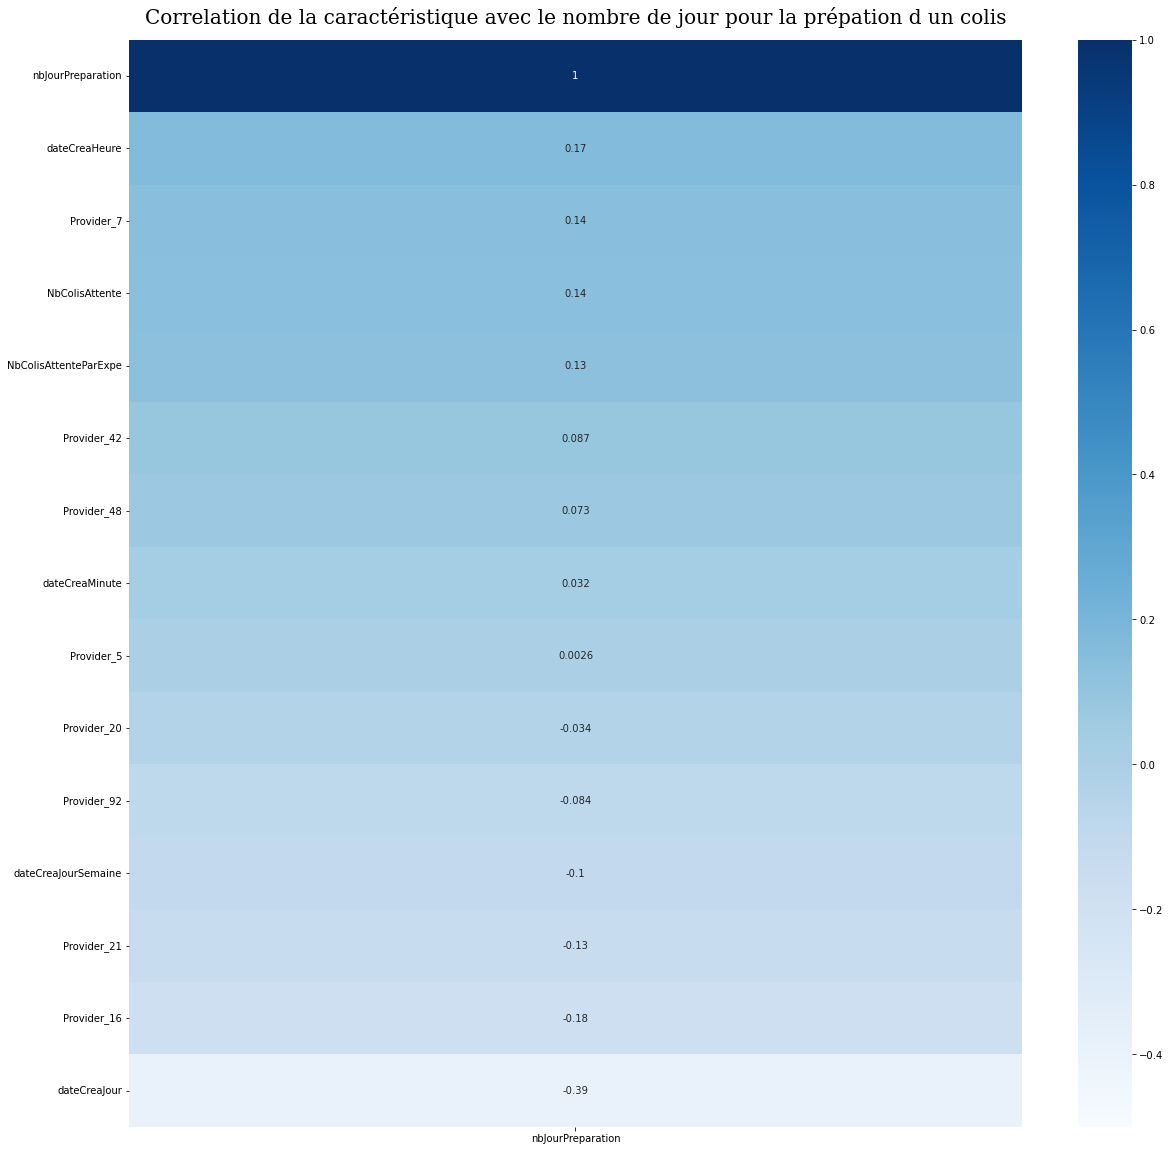

In [98]:
# Nous allons nous concentrez uniquement sur la caractéristique cible
plt.figure(figsize=(20,20))
heatmap = sns.heatmap(df.corr()[['nbJourPreparation']].sort_values(by='nbJourPreparation', ascending=False), vmin=-0.5, vmax=1, annot=True, cmap='Blues')
heatmap.set_title('Correlation de la caractéristique avec le nombre de jour pour la prépation d un colis', pad=16, fontdict={'family': 'serif','size': 20});

In [99]:
# La date de création ( Jour et Mois ) semble fortement corrélées aux nombres de jours de préparations
# On remarque aussi que tous les expediteurs ne possède pas la même corrélation
# On peut cependant fusionner certaines features afin d'augmenter leur pertinence
df['HeureMinute']= df.dateCreaHeure + df.dateCreaMinute /60.0

# On supprime l'ancienne colonne
df = df.drop(['dateCreaHeure'], axis = 1)
df = df.drop(['dateCreaMinute'], axis = 1)

# Global Fonction

In [100]:
# Function qui retourne le grid fitting
def GetScoreHyperparametres(algo, x, y, hyperparametres):
    grid = GridSearchCV(algo, hyperparametres, n_jobs=-1)
    grid.fit(x, y)
    r2Score = round(grid.score(x,y) * 100,2)
    
    #autre metric
    y_pred = grid.predict(x)
    RmseScore = round(metrics.mean_squared_error(y,y_pred),3)
    
    print('Meilleur r2 accuracy pour ce modele : ' + str(r2Score) + '% et rmse pour ce modele : ' + str(RmseScore) + ' avec comme hyperparameters : ' + str(grid.best_estimator_))
    return grid, r2Score, RmseScore 

In [101]:
# Fonction de calcul du temps pour l’ajustement de notation et retourne un tuple
def TimeOfModel(func,*args):
    start_time = time.time()
    return func(*args) , round(time.time() - start_time,3)

In [102]:
# Pour chaque modele, on affiche la précision de r2 et rmse et on garde la meilleur valeur
def BestModelWithoutTraining(namefunc, func):
    bestModel = 1
    bestModelTime = 0
    bestModelExactR2Value = 0
    bestModelExactRmseValue = 0
    incModel = 1
    
    for x in listFeatures:
        InfoModel, time = TimeOfModel(func, x, y)
        print(namefunc + 'Model ' + str(incModel) + ' possède un r2 accuracy : ' + str(InfoModel[0]) + '% et un rmse accuracy ' + str(InfoModel[1]) + ' en ' + str(time) + ' secondes')
        if(bestModelExactR2Value < InfoModel[0]):
                bestModel = incModel
                bestModelTime = time
                bestModelExactR2Value = InfoModel[0]
                bestModelExactRmseValue = InfoModel[1]
        incModel = incModel + 1
    print("Meilleur exacte " + namefunc + " modele est : " + str(bestModel) + ' avec un r2 de ' + str(bestModelExactR2Value) + '% et un rmse de ' + str(bestModelExactRmseValue))
    return [namefunc, str(bestModel), bestModelTime, bestModelExactR2Value, bestModelExactRmseValue]

In [103]:
# Fonction pour prendre le gridsearch sur tout les modeles
def BestModelWithTraining(namefunc, func, algo, hyperparametres):
    bestModel = 1
    bestModelTime = 0
    bestModelExactR2Value = 0
    bestModelExactRmseValue = 0
    incModel = 1
    
    for i in listFeatures:
        print('Calcul du modele ' + str(incModel) + ' en cours ...')
        x_train, x_test, y_train, y_test = train_test_split(i, y, test_size=0.33)
        
        # Scale
        scaler = StandardScaler()
        scaler.fit(x_train)       
        x_train = scaler.transform(x_train, copy = False)
        x_test  = scaler.transform(x_test, copy = False)
        
        # On trouve le model
        InfoModel , time = TimeOfModel(func, algo, x_train, y_train, hyperparametres)           
        
        # Sauvegarder le meilleur model
        if(bestModelExactR2Value < InfoModel[1]):
            bestModel = incModel
            bestModelTime = time
            bestModelExactR2Value = InfoModel[1]
            bestModelExactRmseValue = InfoModel[2]
        incModel = incModel + 1
    print("Meilleur exacte " + namefunc + " modele est : " + str(bestModel) + ' avec un r2 de ' + str(bestModelExactR2Value) + '% et un rmse de ' + str(bestModelExactRmseValue))
    return [namefunc, str(bestModel), bestModelTime, bestModelExactR2Value, bestModelExactRmseValue]

In [104]:
# Genere un dataframe ou stock le meilleur modele pour chaque méthode
ResultDf = pd.DataFrame()
def StockResultDf(tab):
    global ResultDf
    df2 = {'Methode Name': tab[0], 'Model Number': tab[1], 'Time(s)': tab[2], 'R2 Value (%)' : tab[3], 'RMSE Value' : tab[4]}
    ResultDf = ResultDf.append(df2,ignore_index=True)

# Model selection

In [105]:
# On mélange aléatoirement et avec moin de data ( 5% ) pour tester le cross validation qui prend énormement de temp
model = df.sample(frac=1).reset_index(drop=True).loc[:25000]

# On genere un trainset et un dataset
# Target et feature du modele possèdant les colis en attente
y = model["nbJourPreparation"]
model = model.drop(['nbJourPreparation'], axis = 1)

# Le modele suivant ne possedera pas le nombre de colis en attente
model2 = model.drop(['NbColisAttente','NbColisAttenteParExpe'], axis = 1)

# Pour ce troisième modele, on transforme l'heure et les minutes avec sinus pour que les heure proche de midi soit plus importante
model3 = model.copy()
model3['HeureMinute'] = abs(np.cos(2. * np.pi * model3.HeureMinute /24.))

# quatrieme modele comme le troisieme mais on rajoute un scale
model4 = pd.DataFrame(MinMaxScaler().fit_transform(model3.to_numpy()))

# dernier model est comme le premier mais  on rajoute un scale
model5 = pd.DataFrame(MinMaxScaler().fit_transform(model.to_numpy()))

# On crée la liste des caractéristiques
listFeatures = [model, model2, model3, model4, model5]

In [106]:
model3

,dateCreaJour,dateCreaJourSemaine,NbColisAttente,NbColisAttenteParExpe,Provider_5,Provider_7,Provider_16,Provider_20,Provider_21,Provider_42,Provider_48,Provider_92,HeureMinute
0,7,6,45566,32784,0,0,0,0,0,0,1,0,0.321439
1,1,7,76313,58415,0,0,0,0,0,0,1,0,0.074108
2,1,7,66896,50930,0,0,0,0,0,0,1,0,0.999534
3,22,5,66290,50522,0,0,0,0,0,0,1,0,0.694658
4,3,7,287,115,0,0,0,0,1,0,0,0,0.522499
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24996,4,3,77907,60677,0,0,0,0,0,0,1,0,0.465615
24997,1,7,24604,18549,0,0,0,0,0,0,1,0,0.091502
24998,5,2,10176,518,0,1,0,0,0,0,0,0,0.793353
24999,10,2,70229,3592,0,1,0,0,0,0,0,0,0.964787


In [107]:
# On commence avec le modele le plus natif possible
# On commence par calculer un modele natif le plus simple possible
# Le model renverra toujours la valeur de la journée la plus récurente
nbJour = Decimal(y.to_frame().groupby(['nbJourPreparation']).size().max())
nbTotal = Decimal(len(model.axes[0]))

# Rmse metrique
nbJourAttentePlusReccurent = y.to_frame().groupby(['nbJourPreparation']).size().idxmax()
y_pred = [nbJourAttentePlusReccurent]*len(model.axes[0])
RmseScore = round(metrics.mean_squared_error(y,y_pred) * 100,2)

# R2 metrique
result = ((nbJour / nbTotal) * 100).quantize(Decimal('.01'), rounding=ROUND_HALF_UP)
print("Probabilitées que la durée de préparation soit de " + str(nbJourAttentePlusReccurent) + " jour(s) : " + str(result) + "%")

# On sauvegarde le résultat
tab = ["Natif"," - ", 0 ,result, RmseScore]
StockResultDf(tab)

Probabilitées que la durée de préparation soit de 2 jour(s) : 35.19%


In [108]:
# Linear Regression Methode
def LinearRegressionModel(x,y):
    LinearModel = LinearRegression()
    LinearModel.fit(x, y)
    
    #autre metric
    y_pred = LinearModel.predict(x)
    RmseScore = round(metrics.mean_squared_error(y,y_pred),3)
    return round(LinearModel.score(x,y) * 100,2), RmseScore

StockResultDf(BestModelWithoutTraining("Linear Regression", LinearRegressionModel))
ResultDf

Linear RegressionModel 1 possède un r2 accuracy : 29.05% et un rmse accuracy 1.078 en 0.019 secondes
Linear RegressionModel 2 possède un r2 accuracy : 26.3% et un rmse accuracy 1.12 en 0.015 secondes
Linear RegressionModel 3 possède un r2 accuracy : 26.86% et un rmse accuracy 1.111 en 0.021 secondes
Linear RegressionModel 4 possède un r2 accuracy : 26.86% et un rmse accuracy 1.111 en 0.015 secondes
Linear RegressionModel 5 possède un r2 accuracy : 29.05% et un rmse accuracy 1.078 en 0.016 secondes
Meilleur exacte Linear Regression modele est : 1 avec un r2 de 29.05% et un rmse de 1.078


,Methode Name,Model Number,Time(s),R2 Value (%),RMSE Value
0,Natif,-,0.000,35.19,161.820
1,Linear Regression,1,0.019,29.05,1.078


In [109]:
# KNN méthode
def KNN(x,y):
    KnnModel = KNeighborsClassifier(n_neighbors=2)
    KnnModel.fit(x,y)
    #autre metric
    y_pred = KnnModel.predict(x)
    RmseScore = round(metrics.mean_squared_error(y,y_pred),3)
    return round(KnnModel.score(x,y) * 100,2), RmseScore
    
# KNN Methode                                                                   
StockResultDf(BestModelWithoutTraining("KNN", KNN))
ResultDf

KNNModel 1 possède un r2 accuracy : 92.46% et un rmse accuracy 0.228 en 1.15 secondes
KNNModel 2 possède un r2 accuracy : 77.01% et un rmse accuracy 0.422 en 1.196 secondes
KNNModel 3 possède un r2 accuracy : 92.44% et un rmse accuracy 0.23 en 1.09 secondes
KNNModel 4 possède un r2 accuracy : 85.7% et un rmse accuracy 0.272 en 7.108 secondes
KNNModel 5 possède un r2 accuracy : 88.57% et un rmse accuracy 0.221 en 6.853 secondes
Meilleur exacte KNN modele est : 1 avec un r2 de 92.46% et un rmse de 0.228


,Methode Name,Model Number,Time(s),R2 Value (%),RMSE Value
0,Natif,-,0.000,35.19,161.820
1,Linear Regression,1,0.019,29.05,1.078
2,KNN,1,1.150,92.46,0.228


Chaque hyperparamètre à subi différent test et nous gardons que les meilleurs pourcentages pour chaque méthode afin d'obtimiser le temp de compilation

In [110]:
# Lasso
params = {  
            "max_iter"  : [ 50, 100, 250, 500, 1000],
            "alpha"     : [ 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0], 
            "selection" : ["random", "cyclic"]
}
StockResultDf(BestModelWithTraining('Lasso', GetScoreHyperparametres, Lasso(), params))
ResultDf

Calcul du modele 1 en cours ...
Meilleur r2 accuracy pour ce modele : 29.18% et rmse pour ce modele : 1.071 avec comme hyperparameters : Lasso(alpha=0.01, max_iter=50)
Calcul du modele 2 en cours ...
Meilleur r2 accuracy pour ce modele : 26.51% et rmse pour ce modele : 1.105 avec comme hyperparameters : Lasso(alpha=0.01, max_iter=50, selection='random')
Calcul du modele 3 en cours ...
Meilleur r2 accuracy pour ce modele : 26.66% et rmse pour ce modele : 1.119 avec comme hyperparameters : Lasso(alpha=0.01, max_iter=250, selection='random')
Calcul du modele 4 en cours ...
Meilleur r2 accuracy pour ce modele : 26.36% et rmse pour ce modele : 1.112 avec comme hyperparameters : Lasso(alpha=0.01, max_iter=100, selection='random')
Calcul du modele 5 en cours ...
Meilleur r2 accuracy pour ce modele : 28.77% et rmse pour ce modele : 1.089 avec comme hyperparameters : Lasso(alpha=0.01, max_iter=50, selection='random')
Meilleur exacte Lasso modele est : 1 avec un r2 de 29.18% et un rmse de 1.071


,Methode Name,Model Number,Time(s),R2 Value (%),RMSE Value
0,Natif,-,0.000,35.19,161.820
1,Linear Regression,1,0.019,29.05,1.078
2,KNN,1,1.150,92.46,0.228
3,Lasso,1,1.624,29.18,1.071


In [111]:
# AdaBoostRegressor
params = {
    "n_estimators"         : [125, 150, 200],
    'loss'                 : ["linear", "square", "exponential"]
}
StockResultDf(BestModelWithTraining('AdaBoost', GetScoreHyperparametres, AdaBoostRegressor(), params))
ResultDf

Calcul du modele 1 en cours ...
Meilleur r2 accuracy pour ce modele : 38.34% et rmse pour ce modele : 0.945 avec comme hyperparameters : AdaBoostRegressor(n_estimators=150)
Calcul du modele 2 en cours ...
Meilleur r2 accuracy pour ce modele : 39.46% et rmse pour ce modele : 0.924 avec comme hyperparameters : AdaBoostRegressor(n_estimators=150)
Calcul du modele 3 en cours ...
Meilleur r2 accuracy pour ce modele : 43.19% et rmse pour ce modele : 0.868 avec comme hyperparameters : AdaBoostRegressor(n_estimators=150)
Calcul du modele 4 en cours ...
Meilleur r2 accuracy pour ce modele : 38.45% et rmse pour ce modele : 0.94 avec comme hyperparameters : AdaBoostRegressor(n_estimators=150)
Calcul du modele 5 en cours ...
Meilleur r2 accuracy pour ce modele : 34.85% et rmse pour ce modele : 0.988 avec comme hyperparameters : AdaBoostRegressor(n_estimators=200)
Meilleur exacte AdaBoost modele est : 3 avec un r2 de 43.19% et un rmse de 0.868


,Methode Name,Model Number,Time(s),R2 Value (%),RMSE Value
0,Natif,-,0.000,35.19,161.820
1,Linear Regression,1,0.019,29.05,1.078
2,KNN,1,1.150,92.46,0.228
3,Lasso,1,1.624,29.18,1.071
4,AdaBoost,3,12.797,43.19,0.868


In [112]:
# Extra trees
params = {
    "n_estimators"         : [50, 100, 150],
    'max_depth'            : [5],
    'bootstrap'            : [True,False]
}
StockResultDf(BestModelWithTraining('ExtraTrees', GetScoreHyperparametres, ExtraTreesRegressor(), params))
ResultDf

Calcul du modele 1 en cours ...
Meilleur r2 accuracy pour ce modele : 55.53% et rmse pour ce modele : 0.671 avec comme hyperparameters : ExtraTreesRegressor(bootstrap=True, max_depth=5, n_estimators=50)
Calcul du modele 2 en cours ...
Meilleur r2 accuracy pour ce modele : 52.73% et rmse pour ce modele : 0.717 avec comme hyperparameters : ExtraTreesRegressor(max_depth=5, n_estimators=150)
Calcul du modele 3 en cours ...
Meilleur r2 accuracy pour ce modele : 56.05% et rmse pour ce modele : 0.668 avec comme hyperparameters : ExtraTreesRegressor(max_depth=5)
Calcul du modele 4 en cours ...
Meilleur r2 accuracy pour ce modele : 56.39% et rmse pour ce modele : 0.661 avec comme hyperparameters : ExtraTreesRegressor(bootstrap=True, max_depth=5)
Calcul du modele 5 en cours ...
Meilleur r2 accuracy pour ce modele : 55.87% et rmse pour ce modele : 0.67 avec comme hyperparameters : ExtraTreesRegressor(max_depth=5)
Meilleur exacte ExtraTrees modele est : 4 avec un r2 de 56.39% et un rmse de 0.661


,Methode Name,Model Number,Time(s),R2 Value (%),RMSE Value
0,Natif,-,0.000,35.19,161.820
1,Linear Regression,1,0.019,29.05,1.078
2,KNN,1,1.150,92.46,0.228
3,Lasso,1,1.624,29.18,1.071
4,AdaBoost,3,12.797,43.19,0.868
5,ExtraTrees,4,3.924,56.39,0.661


In [113]:
# Random Forest
params = {
    "n_estimators"         : [50, 100, 150],
    'max_depth'            : [5],
    'bootstrap'            : [True,False]
}
StockResultDf(BestModelWithTraining('Random Forest', GetScoreHyperparametres, RandomForestRegressor(), params))
ResultDf

Calcul du modele 1 en cours ...
Meilleur r2 accuracy pour ce modele : 60.41% et rmse pour ce modele : 0.6 avec comme hyperparameters : RandomForestRegressor(max_depth=5, n_estimators=150)
Calcul du modele 2 en cours ...
Meilleur r2 accuracy pour ce modele : 61.16% et rmse pour ce modele : 0.587 avec comme hyperparameters : RandomForestRegressor(max_depth=5)
Calcul du modele 3 en cours ...
Meilleur r2 accuracy pour ce modele : 60.3% et rmse pour ce modele : 0.598 avec comme hyperparameters : RandomForestRegressor(max_depth=5, n_estimators=150)
Calcul du modele 4 en cours ...
Meilleur r2 accuracy pour ce modele : 60.53% et rmse pour ce modele : 0.594 avec comme hyperparameters : RandomForestRegressor(max_depth=5, n_estimators=150)
Calcul du modele 5 en cours ...
Meilleur r2 accuracy pour ce modele : 59.98% et rmse pour ce modele : 0.616 avec comme hyperparameters : RandomForestRegressor(max_depth=5)
Meilleur exacte Random Forest modele est : 2 avec un r2 de 61.16% et un rmse de 0.587


,Methode Name,Model Number,Time(s),R2 Value (%),RMSE Value
0,Natif,-,0.000,35.19,161.820
1,Linear Regression,1,0.019,29.05,1.078
2,KNN,1,1.150,92.46,0.228
3,Lasso,1,1.624,29.18,1.071
4,AdaBoost,3,12.797,43.19,0.868
5,ExtraTrees,4,3.924,56.39,0.661
6,Random Forest,2,5.843,61.16,0.587


In [114]:
# Cross validation
params = {
            'gamma' : [0.85],
            'C' : [2.5],
            'degree' : [0.1, 0.15, 0.2],
            'kernel' : ['rbf','poly','sigmoid','linear'], 
}
StockResultDf(BestModelWithTraining('Cross Validation',GetScoreHyperparametres,svm.SVR(),params))
ResultDf

Calcul du modele 1 en cours ...
Meilleur r2 accuracy pour ce modele : 73.62% et rmse pour ce modele : 0.4 avec comme hyperparameters : SVR(C=2.5, degree=0.1, gamma=0.85)
Calcul du modele 2 en cours ...
Meilleur r2 accuracy pour ce modele : 67.5% et rmse pour ce modele : 0.497 avec comme hyperparameters : SVR(C=2.5, degree=0.1, gamma=0.85)
Calcul du modele 3 en cours ...
Meilleur r2 accuracy pour ce modele : 70.45% et rmse pour ce modele : 0.447 avec comme hyperparameters : SVR(C=2.5, degree=0.1, gamma=0.85)
Calcul du modele 4 en cours ...
Meilleur r2 accuracy pour ce modele : 70.6% et rmse pour ce modele : 0.445 avec comme hyperparameters : SVR(C=2.5, degree=0.1, gamma=0.85)
Calcul du modele 5 en cours ...
Meilleur r2 accuracy pour ce modele : 74.06% et rmse pour ce modele : 0.393 avec comme hyperparameters : SVR(C=2.5, degree=0.1, gamma=0.85)
Meilleur exacte Cross Validation modele est : 5 avec un r2 de 74.06% et un rmse de 0.393


,Methode Name,Model Number,Time(s),R2 Value (%),RMSE Value
0,Natif,-,0.000,35.19,161.820
1,Linear Regression,1,0.019,29.05,1.078
2,KNN,1,1.150,92.46,0.228
3,Lasso,1,1.624,29.18,1.071
4,AdaBoost,3,12.797,43.19,0.868
5,ExtraTrees,4,3.924,56.39,0.661
6,Random Forest,2,5.843,61.16,0.587
7,Cross Validation,5,267.232,74.06,0.393


In [115]:
# XGBoost
params = {
    "max_depth" : [4],
    "gamma" : [0.0025, 0.077, 0.1, 0.25]
}
StockResultDf(BestModelWithTraining('XGBoost', GetScoreHyperparametres, XGBRegressor(), params))
ResultDf

Calcul du modele 1 en cours ...
Meilleur r2 accuracy pour ce modele : 82.34% et rmse pour ce modele : 0.267 avec comme hyperparameters : XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.25, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)
Calcul du modele 2 en cours ...
Meilleur r2 accuracy pour ce modele : 75.85% et rmse pour ce modele : 0.366 avec comme hyperparameters : XGBRegressor(base_score=0.5, boost

,Methode Name,Model Number,Time(s),R2 Value (%),RMSE Value
0,Natif,-,0.000,35.19,161.820
1,Linear Regression,1,0.019,29.05,1.078
2,KNN,1,1.150,92.46,0.228
3,Lasso,1,1.624,29.18,1.071
4,AdaBoost,3,12.797,43.19,0.868
5,ExtraTrees,4,3.924,56.39,0.661
6,Random Forest,2,5.843,61.16,0.587
7,Cross Validation,5,267.232,74.06,0.393
8,XGBoost,3,4.469,82.44,0.269


In [116]:
# Bagging Regressor
from sklearn.ensemble import BaggingRegressor
params = {
    "n_estimators"         : [10, 25],
    'bootstrap'            : [True,False]
}
StockResultDf(BestModelWithTraining('Bagging Regressor', GetScoreHyperparametres, BaggingRegressor(), params))
ResultDf

Calcul du modele 1 en cours ...
Meilleur r2 accuracy pour ce modele : 98.25% et rmse pour ce modele : 0.026 avec comme hyperparameters : BaggingRegressor(n_estimators=25)
Calcul du modele 2 en cours ...
Meilleur r2 accuracy pour ce modele : 89.89% et rmse pour ce modele : 0.156 avec comme hyperparameters : BaggingRegressor(n_estimators=25)
Calcul du modele 3 en cours ...
Meilleur r2 accuracy pour ce modele : 98.36% et rmse pour ce modele : 0.025 avec comme hyperparameters : BaggingRegressor(n_estimators=25)
Calcul du modele 4 en cours ...
Meilleur r2 accuracy pour ce modele : 98.53% et rmse pour ce modele : 0.022 avec comme hyperparameters : BaggingRegressor(n_estimators=25)
Calcul du modele 5 en cours ...
Meilleur r2 accuracy pour ce modele : 98.22% et rmse pour ce modele : 0.027 avec comme hyperparameters : BaggingRegressor(n_estimators=25)
Meilleur exacte Bagging Regressor modele est : 4 avec un r2 de 98.53% et un rmse de 0.022


,Methode Name,Model Number,Time(s),R2 Value (%),RMSE Value
0,Natif,-,0.000,35.19,161.820
1,Linear Regression,1,0.019,29.05,1.078
2,KNN,1,1.150,92.46,0.228
3,Lasso,1,1.624,29.18,1.071
4,AdaBoost,3,12.797,43.19,0.868
5,ExtraTrees,4,3.924,56.39,0.661
6,Random Forest,2,5.843,61.16,0.587
7,Cross Validation,5,267.232,74.06,0.393
8,XGBoost,3,4.469,82.44,0.269
9,Bagging Regressor,4,4.399,98.53,0.022


# Conclusion

 - La méthode la plus rapide est celle de la régression linéaire
 - Les meilleures caractéristiques sont obtenues avec le modèle n°3
 - La plus grande précision est fournie par la méthode Bagging Regressor

In [117]:
# On genere le model
gridResult = GetScoreHyperparametres(BaggingRegressor(), listFeatures[2], y, params)[0]
feature_importances = np.mean([tree.feature_importances_ for tree in gridResult.best_estimator_.estimators_], axis=0)

# On le stock dans un dataframe
df_bestFeature = pd.DataFrame()
df_bestFeature['Name'] = listFeatures[2].columns.values
df_bestFeature['score'] = feature_importances
df_bestFeature = df_bestFeature.sort_values(by=['score'], ascending=False).reset_index(drop=True)
df_bestFeature

Meilleur r2 accuracy pour ce modele : 98.73% et rmse pour ce modele : 0.019 avec comme hyperparameters : BaggingRegressor(n_estimators=25)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


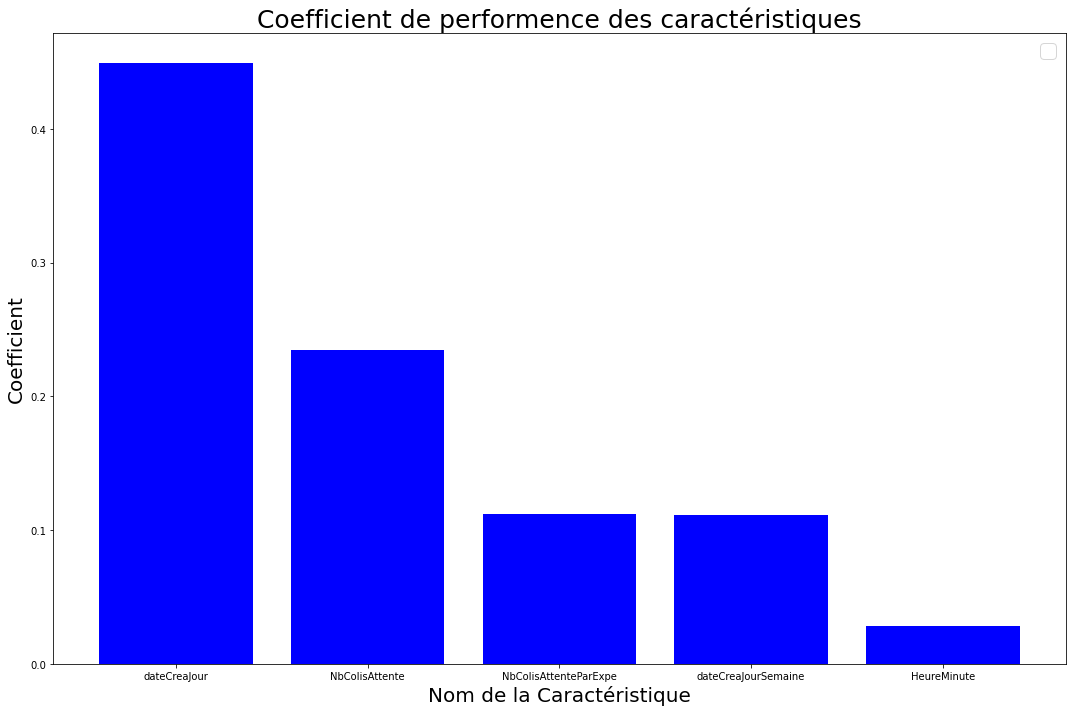

In [140]:
fig, ax = plt.subplots()
p1 = ax.bar(df_bestFeature['Name'].iloc[:5], df_bestFeature['score'].iloc[:5], color='b')

plt.gcf().set_size_inches(15,10)
plt.title("Coefficient de performence des caractéristiques", fontsize = 25)
plt.xlabel('Nom de la Caractéristique', fontsize = 20)
plt.ylabel('Coefficient', fontsize = 20)
fig.tight_layout()
ax.legend(fontsize=20)
plt.show()

La variable la plus performante est le jour de création de la commande suivie du nombre de colis en attente. 
Ce résultat me semble surprenant car il me semblerais logique que le nombre de colis en attente soit plus pertinent que la date de création de la commande.

# How do you go to production 

How to reduce the response time ?

In [37]:
# On suppose que le colis à les caractéristique suivante
# - Commandé le 7 février à 12h
# - C'est un Jeudi
# - Il y'a 1000 colis en attente dont 100 dans l'expediteur conserné

#On crée un dataframe
dtPredict = pd.DataFrame()

# On selectionne les providers dynamiquement
listProvider = [col for col in model.columns if col.startswith('Provider_')]
tabPredict = [[0]*10]*10

# On insere les expéditeurs
for i in range(len(tabPredict)):
    tabPredict[i][i] = 1 

# On créer notre liste de prédiction
dtPredict["dateCreaJour"] = [7] * len(listProvider)
dtPredict["HeureMinute"] = [0.5] * len(listProvider)
dtPredict["dateCreaJourSemaine"] = [4] * len(listProvider)
dtPredict["NbColisAttente"] = [1000] * len(listProvider)
dtPredict["NbColisAttenteParExpe"] = [100] * len(listProvider)

for provider in listProvider:
    provider = provider.lstrip("Provider_")

df_provider = pd.get_dummies(listProvider)
dtPredict = dtPredict.join(df_provider)
dtPredict

,dateCreaJour,HeureMinute,dateCreaJourSemaine,NbColisAttente,NbColisAttenteParExpe,Provider_16,Provider_20,Provider_21,Provider_42,Provider_48,Provider_5,Provider_7,Provider_92
0,7,0.5,4,1000,100,0,0,0,0,0,1,0,0
1,7,0.5,4,1000,100,0,0,0,0,0,0,1,0
2,7,0.5,4,1000,100,1,0,0,0,0,0,0,0
3,7,0.5,4,1000,100,0,1,0,0,0,0,0,0
4,7,0.5,4,1000,100,0,0,1,0,0,0,0,0
5,7,0.5,4,1000,100,0,0,0,1,0,0,0,0
6,7,0.5,4,1000,100,0,0,0,0,1,0,0,0
7,7,0.5,4,1000,100,0,0,0,0,0,0,0,1


In [38]:
#On prédit avec le modele
# On prend le meilleur modele et l'on réalise la prédiction pour chaque transporteur différent
# On regenere un modele
algo = BaggingRegressor()
params = {
    "n_estimators"         : [10, 25],
    'bootstrap'            : [True,False]
}
gridPredict = GetScoreHyperparametres(algo, listFeatures[2], y, params)[0]
result = gridPredict.predict(dtPredict.values.tolist())

Meilleur r2 accuracy pour ce modele : 98.78% et rmse pour ce modele : 0.019 avec comme hyperparameters : BaggingRegressor(n_estimators=25)


In [39]:
#On trouve l'index du provider qui propose le service le plus rapide
import math
def get_indexes_min_value(l):
    min_value = min(l)
    return l.index(min(l))

result = np.floor(result)
BestProviderIndex  = get_indexes_min_value(result.tolist())
BestProviderIndex

3

In [40]:
#Resultat
print("Pour cette commande, le meilleur expéditeur semble être le " + str(listProvider[BestProviderIndex]))

Pour cette commande, le meillieur provider semble être le Provider_20
